In [3]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
import porepy as pp

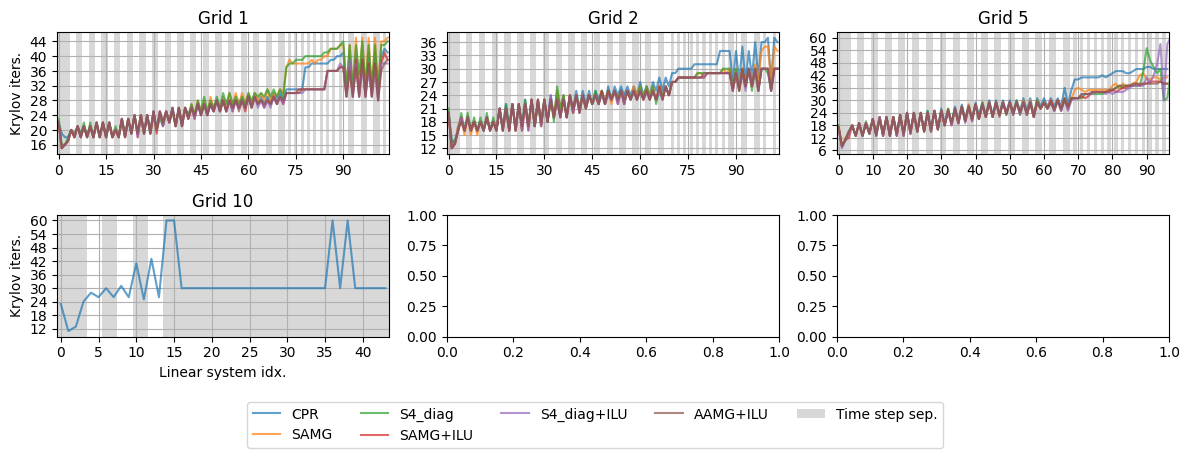

In [5]:
grids = [
    1,
    2,
    5,
    10,
    # 15,
    # 20,
    # 25
]

data = {}
names = {}
solvers = ['CPR', 'SAMG', 'S4_diag', 'SAMG+ILU', 'S4_diag+ILU', 'AAMG+ILU']
s = 'CPR'

data = {}
names = {}
for i, g in enumerate(grids):
    data[i] = {}
    names[i] = f"Grid {g}"
    for s in solvers:
        try:
            data[i][s] = load_data(f"../stats/stats_thermal_geo5x{g}_sol{s}.json")
        except:
            continue


shape = [2, 3]
figsize = (12, 4)


def render_element(i, data):
    if len(data) == 0:
        return
    for solver_name, d in data.items():
        # color_converged_reason(d, legend=True)
        plt.plot(get_gmres_iterations(d), label=solver_name, alpha=0.7)
        # plt.twinx()
        # DAY = 3600 * 24
        # plt.plot(np.cumsum(get_time_steps(data)) / DAY , color='black', alpha=0.5, label='Time')
    plt.gca().grid(True)
    set_integer_ticks("vertical")
    color_time_steps(data['CPR'], fill=True, legend=True)
    # plt.yscale('log')


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

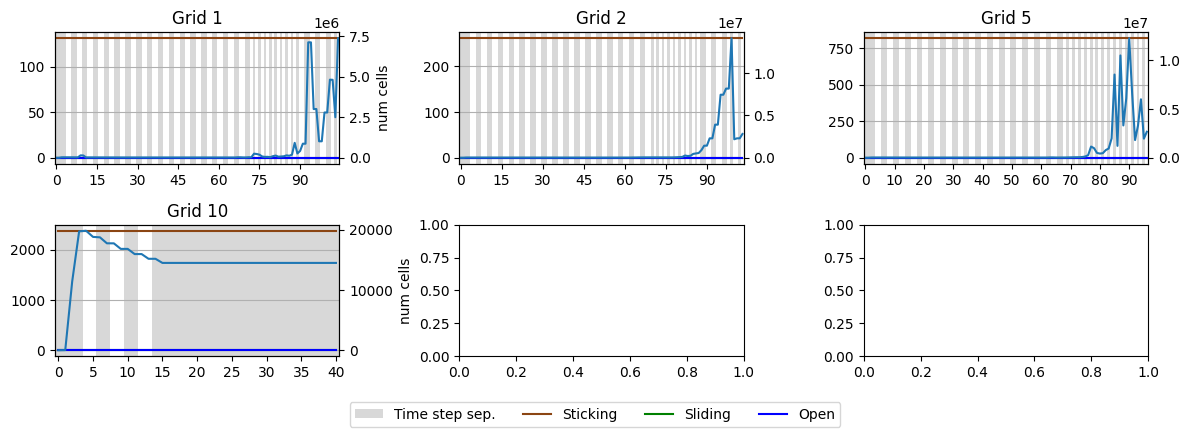

In [10]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    entry = entry.get('CPR')
    if entry is None:
        return
    st, sl, op = get_num_sticking_sliding_open(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.gca().grid(False)
    plt.gca().grid(True, which="major", axis="y")
    marker = None
    plt.plot(st, label="Sticking", marker=marker, color=COLOR_STICKING)
    plt.plot(sl, label="Sliding", marker=marker, color=COLOR_SLIDING)
    plt.plot(op, label="Open", marker=marker, color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)

    cfl = get_cfl(entry)
    peclet_max = get_peclet_max(entry)
    peclet_mean = get_peclet_mean(entry)
    plt.twinx()
    # plt.plot(cfl, label='CFL')
    plt.plot(peclet_max, label=r'$P_{max}$')
    # plt.yscale('log')

plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="num cells",
    ax_titles=names,
    #   ylabel="Fract. len., m"
)
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

In [7]:
from collections import defaultdict
import pandas as pd

table = dict()

NDIGITS = 3

for g in grids:
    table[g] = {}
    for s in solvers:
        stats_name = f"stats_thermal_geo5x{g}_sol{s}.json"
        try:
            entry = load_data(f"../stats/{stats_name}")
            dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
        except FileNotFoundError:
            continue
        total_dofs = dofs_info["total dofs"]
        table[g]["Total DoFs"] = str(int(total_dofs))
        table[g][s] = round(np.mean(get_gmres_iterations(entry)), NDIGITS)

        # if g in [1, 2, 5]:
        #     direct = load_data(f"../stats/stats_geo0x{g}_sol{21}_ph{1}_bb{2}_fr{1}.json")
        #     table["GMRES dir."].append(round(np.mean(get_gmres_iterations(direct)), NDIGITS))
        # else:
        #     table["GMRES dir."].append('-')

        # table['Newton iters.'].append(round(np.mean(get_newton_iterations(entry)), NDIGITS))
        converged_reason = get_petsc_converged_reason(entry)
        # table['\# lim iters.'].append(sum(np.array(get_petsc_converged_reason(entry)) < 0))

table = pd.DataFrame(table)
table.rename(columns=table.iloc[0], inplace=True)
table = table[1:]
table.columns.name = 'Total DoFs'
table

Total DoFs,5643,12688,60297,298901
CPR,27.524,24.827,28.68,17.0
SAMG,28.686,23.683,26.649,NaN
S4_diag,28.886,23.49,26.49,NaN
SAMG+ILU,26.419,23.221,25.845,NaN
S4_diag+ILU,26.324,23.192,26.48,NaN
AAMG+ILU,26.4,23.269,26.021,NaN


In [5]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal_runscript_5 import make_model
import porepy as pp

model = make_model(
    {
        "geometry": 5,
        "grid_refinement": 10,
        "solver": 3,
        'steady_state': True,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.00e+00, Dt: 1.00e+00 (days)
Temperature: 393.00, 393.00
sticking: 2379, sliding: 0, open: 0


In [6]:
# mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
#     load_data(f"../stats/{model.simulation_name()}.json"), 9
# )

mat = scipy.sparse.load_npz('../matrices/stats_thermal_geo5x10_sol3_1739045561550.npz')
rhs = np.load('../matrices/stats_thermal_geo5x10_sol3_1739045561550_rhs.npy')
iterate = np.load('../matrices/stats_thermal_geo5x10_sol3_1739045561550_iterate.npy')
state = np.load('../matrices/stats_thermal_geo5x10_sol3_1739045561550_state.npy')
dt = 4e-3

In [7]:
model.linear_system = mat, rhs
model.bmat.mat = mat
model.equation_system.set_variable_values(state, time_step_index=0)
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.ad_time_step.set_value(dt)
model.time_manager.dt = dt

(298901, 298901)

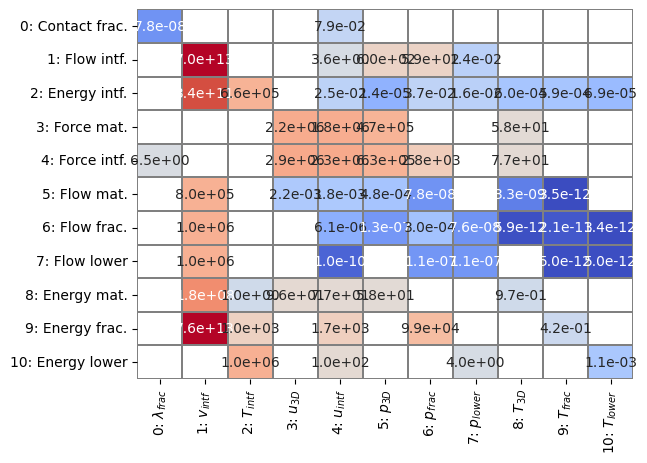

In [8]:
J = model.bmat[:]
J.plot_max()
J.shape

Construction took: 18.92
  0 KSP Residual norm 3.478483018294e-01 
  1 KSP Residual norm 3.478140369611e-01 
  2 KSP Residual norm 3.453602947504e-01 
  3 KSP Residual norm 3.255226229604e-01 
  4 KSP Residual norm 3.059570467062e-01 
  5 KSP Residual norm 2.174708149915e-01 
  6 KSP Residual norm 1.814721343469e-01 
  7 KSP Residual norm 8.753399418555e-02 
  8 KSP Residual norm 2.615325078754e-02 
  9 KSP Residual norm 7.434694881658e-03 
 10 KSP Residual norm 3.068138919802e-03 
 11 KSP Residual norm 1.180986815863e-03 
 12 KSP Residual norm 2.140001792467e-04 
 13 KSP Residual norm 1.133432208753e-04 
 14 KSP Residual norm 7.790557388752e-05 
 15 KSP Residual norm 6.015884574326e-05 
 16 KSP Residual norm 5.358779664274e-05 
 17 KSP Residual norm 4.721746937907e-05 
 18 KSP Residual norm 2.598116497372e-05 
 19 KSP Residual norm 9.435028345882e-06 
 20 KSP Residual norm 4.786374026362e-06 
 21 KSP Residual norm 3.075269506158e-06 
 22 KSP Residual norm 2.594202919324e-06 
 23 KSP R

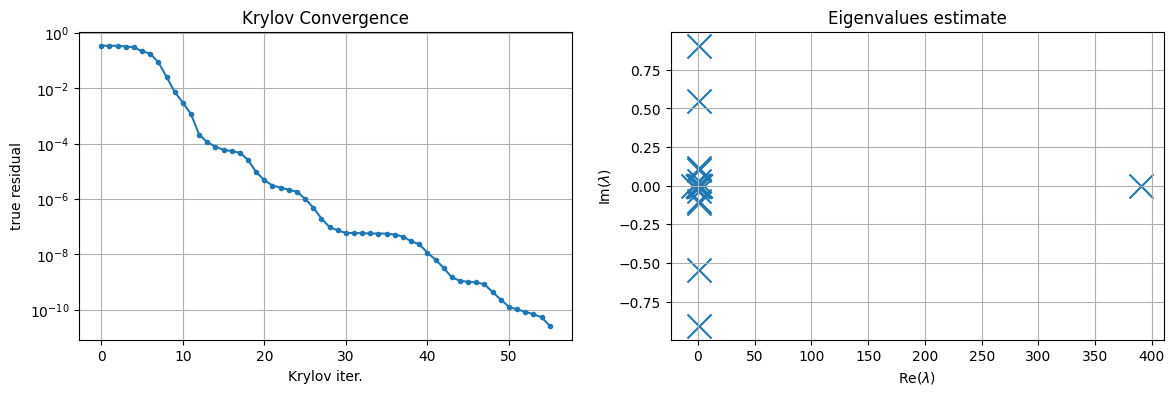

In [ ]:
from fixed_stress import make_fs_analytical, make_fs_analytical_slow_new
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *
from full_petsc_solver import *

contact = [0]
intf = [1, 2]
mech = [3, 4]
flow = [5, 6, 7]
temp = [8, 9, 10]
scheme = LinearTransformedScheme(
    right_transformations=[lambda bmat: model.Qright(contact_group=0, u_intf_group=4)],
    inner=PetscKSPScheme(
        petsc_options={
            # "ksp_type": "fgmres",
            "ksp_monitor": None,
        },
        compute_eigenvalues=True,
        preconditioner=PetscFieldSplitScheme(
            groups=contact,
            block_size=model.nd,
            fieldsplit_options={
                "pc_fieldsplit_schur_precondition": "selfp",
            },
            subsolver_options={
                "pc_type": "pbjacobi",
            },
            tmp_options={
                "mat_schur_complement_ainv_type": "blockdiag",
            },
            complement=PetscFieldSplitScheme(
                groups=intf,
                subsolver_options={
                    "pc_type": "ilu",
                },
                fieldsplit_options={
                    "pc_fieldsplit_schur_precondition": "selfp",
                },
                complement=PetscFieldSplitScheme(
                    groups=mech,
                    subsolver_options=(
                        {
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                            "pc_hypre_boomeramg_strong_threshold": 0.7,
                            "pc_hypre_boomeramg_smooth_type": "Euclid",
                        }
                    ),
                    tmp_options={
                    },
                    block_size=model.nd,
                    invert=lambda bmat: csr_to_petsc(
                        make_fs_analytical_slow_new(
                            model,
                            bmat,
                            p_mat_group=5,
                            p_frac_group=6,
                            groups=flow + temp,
                        ).mat,
                        bsize=1,
                    ),
                    complement=PetscCPRScheme(
                        groups=flow + temp,
                        pressure_groups=flow,
                        pressure_options={
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                            "pc_hypre_boomeramg_strong_threshold": 0.7,
                            "pc_hypre_boomeramg_smooth_type": "Euclid",
                        },
                        others_options={
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                            "pc_hypre_boomeramg_strong_threshold": 0.7,
                        },
                        cpr_options={
                            "pc_composite_pcs": "fieldsplit,ksp",
                            "sub_1_ksp_ksp_type": "preonly",
                            "sub_1_ksp_pc_type": "hypre",
                            "sub_1_ksp_pc_hypre_type": "Euclid",
                        },
                    ),
                ),
            ),
        ),
    ),
)

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=scheme,
    ksp_view=True,
)